In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg
np.set_printoptions(precision=3)

plt.rcParams['figure.figsize'] = [15, 15]

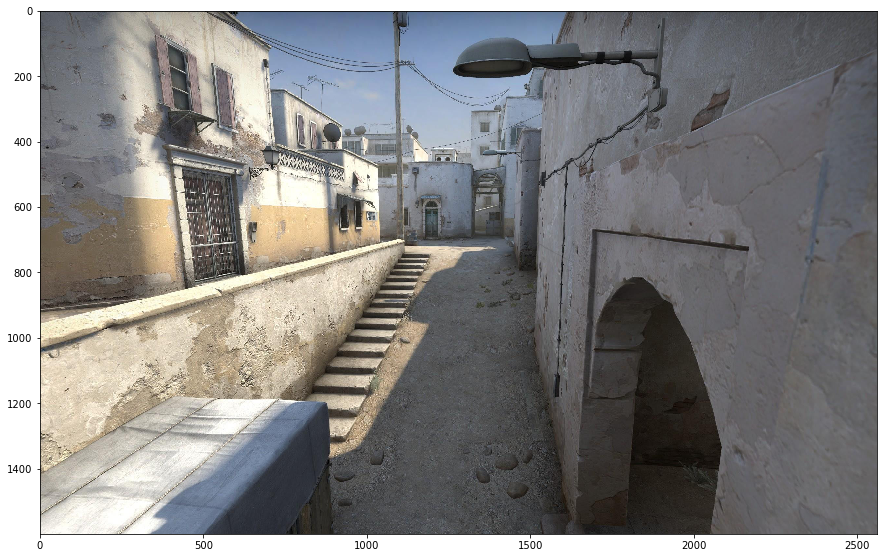

In [2]:
img = Image.open('data/2020-04-10-Finding-Vanishing-Points/csgo-dust2-mid.jpeg')
plt.imshow(img)
plt.show()

In [3]:
vanishing_points = {'VP1': [1371.892,  630.421],
                    'VP2': [-10651.54 ,    536.681],
                    'VP3': [1272.225, 7683.02 ]}

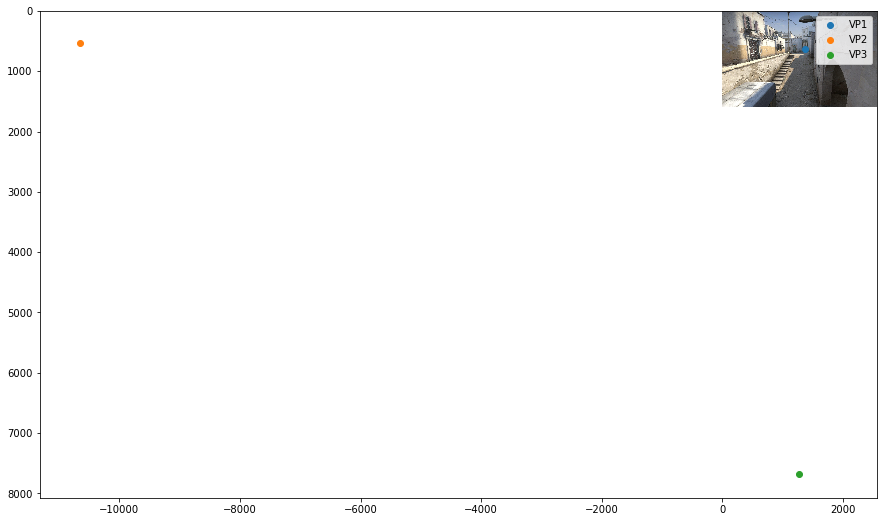

In [4]:
plt.imshow(img)
for point_name in ['VP1','VP2','VP3']:
    vp = vanishing_points[point_name]
    plt.scatter(vp[0],vp[1],label=point_name)
plt.legend()
plt.show()

Ok, so we now have three different vanishing points. Using these, let's try and use them to gain some insights into the cameras' relationship with the scene.

Hartley & Zisserman put it best, "Vanishing points are images of points at infinity, and provide orientation (attitude) in- formation in a similar manner to that provided by the fixed stars."


Hartley & Zisserman also provide an algorithm (Example 8.27, page 226) to extract the camera calibration matrix K from 3 mutually orthogonal vanishing points.

Let's go and implement it in practice.




### Some algebra

H&Z propose a matrix $\omega$ (omega), which captures the following relationship between the different vanishing points.

$v^T_i \omega v_j = 0$
 
Where:
 
$\omega = \begin{bmatrix}
w_1 & 0 & w_2\\
0 & w_1 & w_3\\
w_2 & w_3 & w_4
\end{bmatrix}$
 
And:

$ v_j = \begin{bmatrix}
x_1\\
y_1\\
1
\end{bmatrix}$

$v_i = \begin{bmatrix}
x_2 \\ y_2 \\ 1
\end{bmatrix}$

If we can find this matrix $\omega$, then we can find the camera calibration matrix if we make some assumptions:

1. Zero Skew 
2. Square Pixels

From H&Z, we have: "K is obtained from $\omega$ by Cholesky factorization of omega, followed by inversion."

For good practice, we can also normalize the matrix so that the lower right value $K_{22}$ is 1. 
In python:
```python
K = np.linalg.inv(np.linalg.cholesky(omega)).T
K/=K[2,2]
```

Working backwards, we are faced with the task of finding $\omega$


Multiplying through, we find that:

$ v^T_i \omega v_j = x_2(w_1 x_1 + w_2) + y_2(w_1  y_1 + w_3) + w_2  x_1 + w_3  y_1 + w_4$

Factorising:

$  v^T_i \omega v_j= w_1(x_2 x_1 + y_2 y_1) +  w_2(x_2 + x_1) + w_3(y_2 + y_1) + w_4$

Great, we can now find all the coefficients we need for our matrix from each pair of vanishing points.

We have three pairs of vanishing points:
1. 1 & 2
2. 2 & 3
3. 3 & 1 

From each pair we can find a new set of values for $w_1$ to $w_4$.

Stacking them all on top of each other, we end up with the matrix $A$.

$A = \begin{bmatrix}
w_{11} & w_{12} & w_{13} & w_{14}\\
w_{21} & w_{22} & w_{23} & w_{24}\\
w_{31} & w_{32} & w_{33} & w_{34}
\end{bmatrix}$

In Python:

```python
def generate_A(vanishing_points):
    A = []
    for (point_name_1, point_name_2) in [('VP1','VP2'),('VP2','VP3'),('VP3','VP1')]:    
        vp1 = vanishing_points[point_name_1]
        vp2 = vanishing_points[point_name_2]

        x1,y1 = vp1
        x2,y2 = vp2

        w1 = x2*x1 + y2*y1
        w2 = x2 + x1 
        w3 = y2 + y1
        w4 = 1  
        A.append([w1,w2,w3,w4])
        
    A = np.array(A)
    return(A)
```

In [21]:
def generate_A(vanishing_points):
    A = []
    for (point_name_1, point_name_2) in [('VP1','VP2'),('VP2','VP3'),('VP3','VP1')]:    
        vp1 = vanishing_points[point_name_1]
        vp2 = vanishing_points[point_name_2]

        x1,y1 = vp1
        x2,y2 = vp2

        w1 = x2*x1 + y2*y1
        w2 = x2 + x1 
        w3 = y2 + y1
        w4 = 1  
        A.append([w1,w2,w3,w4])
        
    A = np.array(A)
    return(A)

def compute_K(A):
    w = scipy.linalg.null_space(A).ravel()
    
    w1 = w[0]
    w2 = w[1]
    w3 = w[2]
    w4 = w[3]

    omega = np.array([[w1,0,w2],
                      [0,w1,w3],
                      [w2,w3,w4]])
    K = np.linalg.inv(np.linalg.cholesky(omega)).T
    K/=K[2,2]
    return(K)

A = generate_A(vanishing_points)
K = compute_K(A)

In [24]:
print(K)

[[7.276e+02 0.000e+00 1.327e+03]
 [6.236e-14 7.276e+02 7.060e+02]
 [1.218e-16 0.000e+00 1.000e+00]]


### The Calibration Matrix
So now we have the calibration matrix $K$, which gives us three separate pieces of information.

1. The Focal length in pixels: $K_{11}$ or $K_{22}$ (728)
2. The x coordinate of the camera optical centre: $K_{13}$ (1327)
2. The y coordinate of the camera optical centre $K_{23}$ (706)

$K  = \begin{bmatrix}
728 & 0 & 1327\\
0 & 728 & 706\\
0 & 0 & 1
\end{bmatrix}$


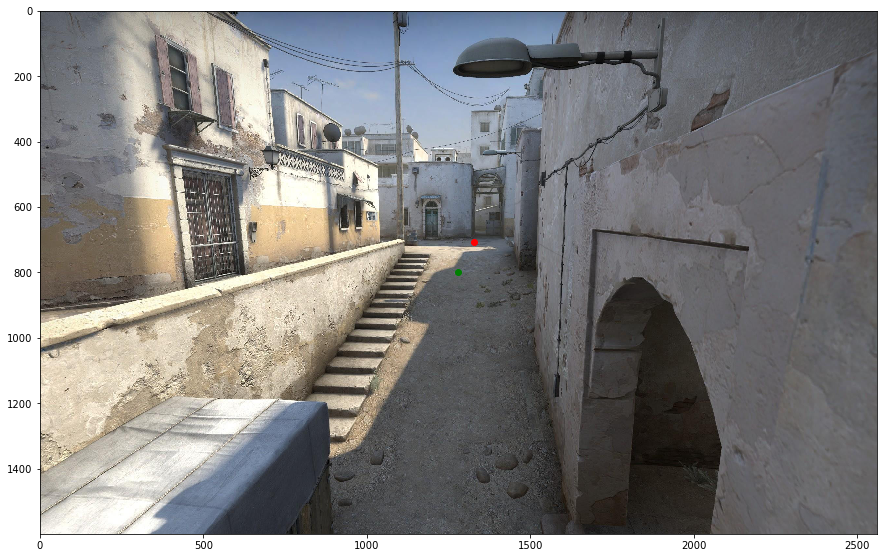

In [25]:
plt.scatter(2560/2.0,1600/2.0,color='G')
plt.scatter(K[0,2],K[1,2],color='R')
plt.imshow(img)
plt.show()